## Exercise Sheet 6: Missing Data and Feature selection
### <i> INF161 - Data Science </i>

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import warnings

plt.style.use('ggplot')

### Excercise 1: Detecting, plotting and handling missing values in the Diabetes dataset

In [2]:
# Loading dataset
diabetes = pd.read_csv('../Datasets/diabetes.csv')
patient_data = diabetes[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']]

patient_data.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148,72,35,0,33.6
1,85,66,29,0,26.6
2,183,64,0,0,23.3
3,89,66,23,94,28.1
4,137,40,35,168,43.1


This dataset consist of
several feature variables, and one target variable (Outcome). Missing values are denoted as '0'.

In [3]:
# Count the number of values denoted by '0' (missing)
for column in patient_data.columns:
    try:
        print(f'{column}:', f'{patient_data[column].value_counts(sort=True).loc[0]}')

    # If there are no values of 0 in the column, a KeyError will be raised
    except KeyError:
        print(f'{column}:', 0)
        continue

Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11


Let's compare the distribution of the columns before and after converting missing values from 0 to None.

In [4]:
# Setting figure size for the figure below
plt.rcParams["figure.figsize"] = (30,20)

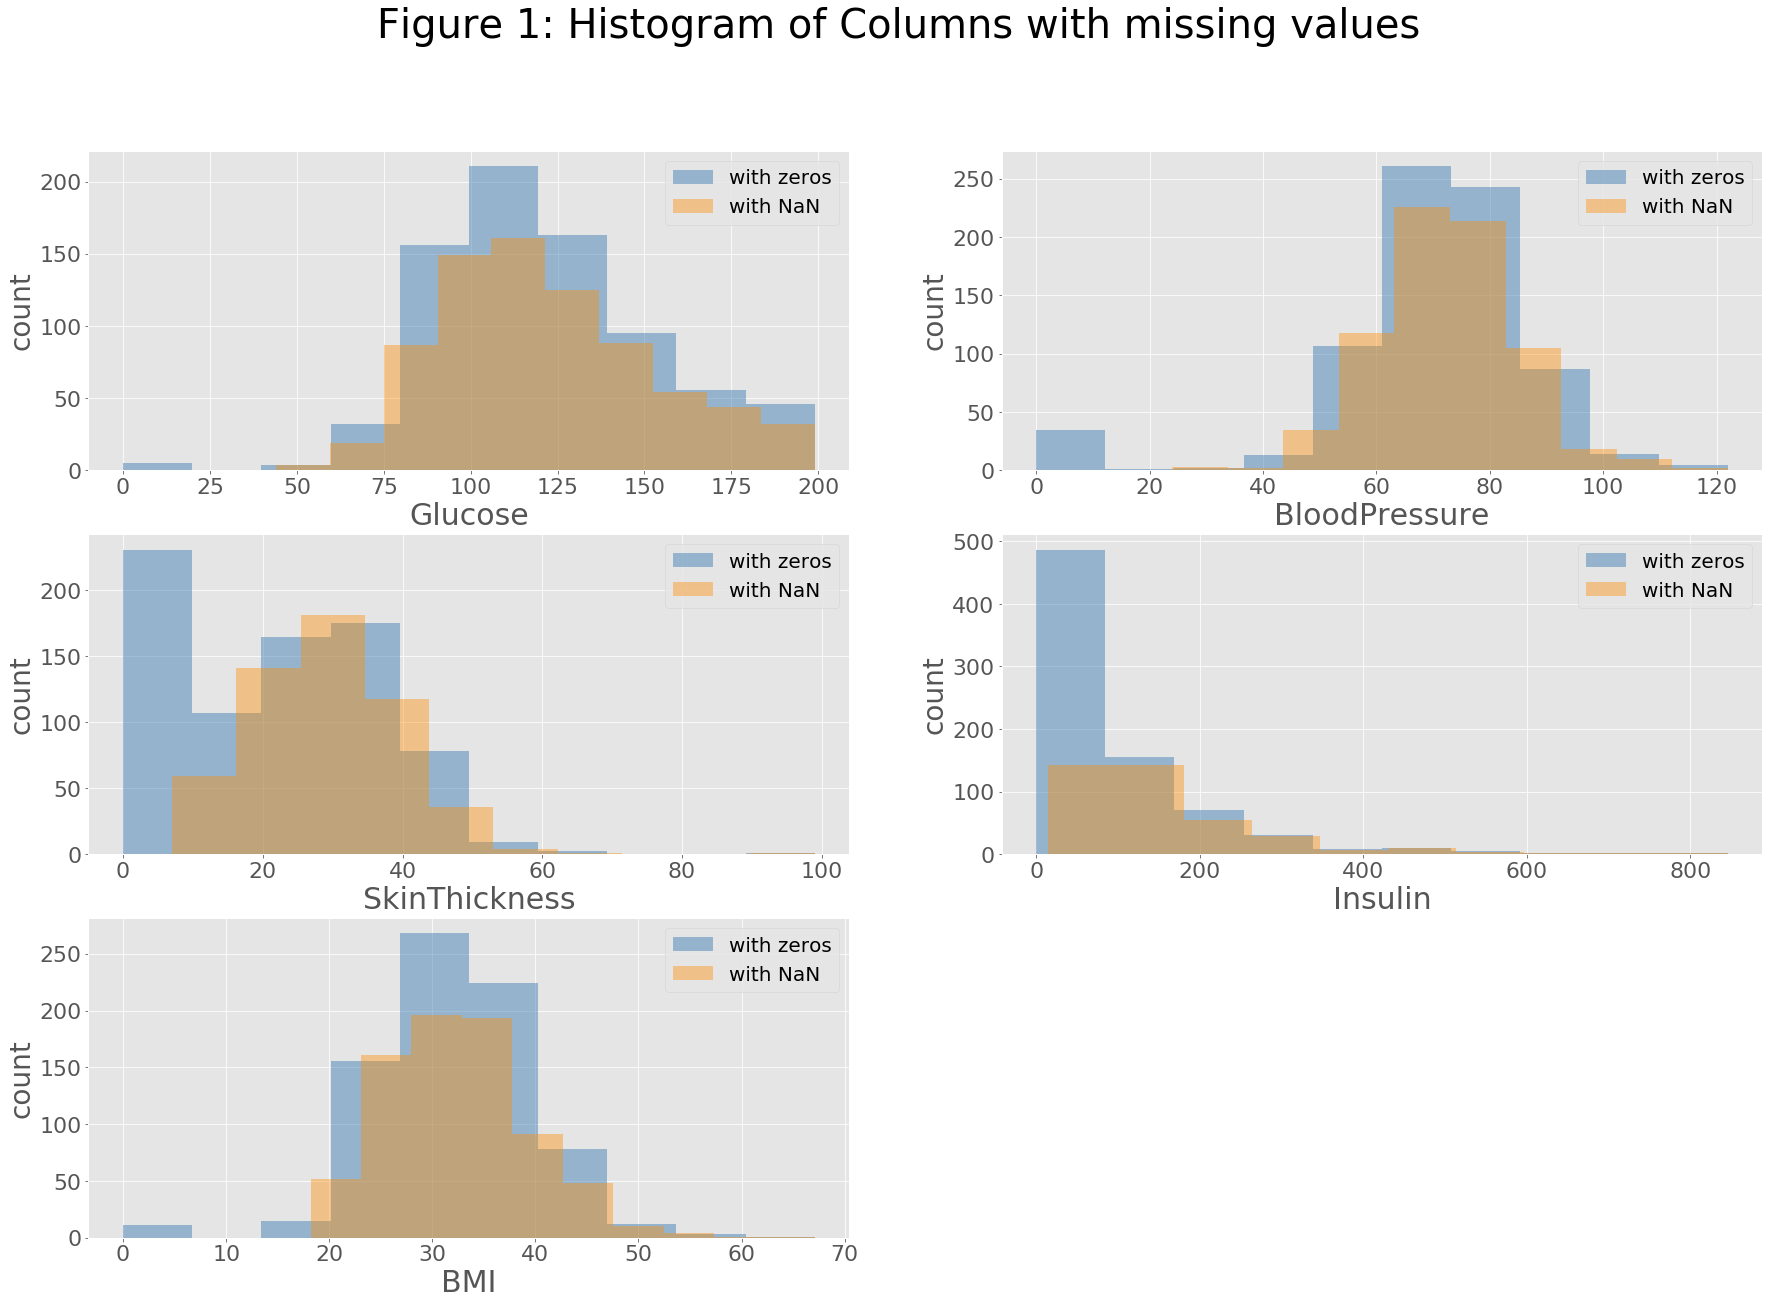

In [5]:
diabetes_NaN = patient_data.replace(0, np.nan)
# Apparently Jupyter Notebook doesn't like plotting bar charts with nan values. 
# Suppressing RuntimeWarning temporarily.  
warnings.filterwarnings("ignore",category=RuntimeWarning)

# Plotting the histogram of the columns before and after marking zero values as Nan.
fig, ax = plt.subplots(nrows=3, ncols=2)
i = 0
j = 0

for column in patient_data.columns:
    with_zeros = diabetes[column]
    with_NaN = diabetes_NaN[column]

    ax[i, j].hist(with_zeros, label='with zeros', alpha=0.5,
                  color='steelblue')
    ax[i, j].hist(with_NaN, label='with NaN', alpha=0.4,
                  color='darkorange')
    ax[i, j].set_ylabel('count', size=28)
    ax[i, j].set_xlabel(column, size=30)
    ax[i, j].legend(prop={'size': 20})
    ax[i, j].tick_params(axis='x', labelsize=22)
    ax[i, j].tick_params(axis='y', labelsize=22)

    # Some logic for displaying each plot correctly in the figure
    if i == 0 and j == 0:
        j = 1
    elif i == 0 and j == 1:
        i, j = 1, 0
    elif i == 1 and j == 0:
        j = 1
    elif i == 1 and j == 1:
        i, j = 2, 0

fig.suptitle('Figure 1: Histogram of Columns with missing values', fontsize=40)

ax[2, 1].remove()

plt.show()

As shown in the figure above, it is important to replace missing values that are notated with 0 with NaN instead. This is mainly because 0's are included in numerical operations made on the data, while NaN values are not. In the case of the diabetes dataset, denoting missing values with a 0 is simply incorrect because the value conveys that the measurement was 0, not that the measurement itself was lacking. For example, there are no (living) patients who have a blood pressure or skin thickness of 0. On the other hand, some patients might actually have an insulin level of 0, so showing missing insulin values as 0 in the histogram will invalidate any statistical inferences that are made on the dataset. 

Next, I will try three different imputation methods to handle the missing values, and measure the performance of each when used in a K-nearest-neighbors classifier. 

In [6]:
# Feature selection
X = diabetes[['Glucose', 'Insulin', 'BloodPressure', 'SkinThickness', 'BMI', 'Age']]
y = diabetes.Outcome

# Missing values are denoted with 0's in the dataset. Replacing with Numpy's NaN-values
X = X.replace(0, np.NaN)

In [7]:
# Splitting dataset into training, validation and test data (60%, 20%, 20%).
# Setting random_state=1 so we get the same split every time
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=1)  
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=1)

In [8]:
# Replacing the NaN values in the training and validation datasets with the column mean
imputer_mean = SimpleImputer(strategy='mean')
imputer_mean.fit(X_train)
X_train_meanfill = imputer_mean.transform(X_train)
X_val_meanfill = imputer_mean.transform(X_val)
print(X_train_meanfill[3].tolist())

# Replacing the NaN values in the training and validation datasets with the column median
imputer_median = SimpleImputer(strategy='median')
imputer_median.fit(X_train)
X_train_medianfill = imputer_median.transform(X_train)
X_val_medianfill = imputer_median.transform(X_val)
print(X_train_medianfill[3].tolist())

# Replacing the NaN values in the training and validation datasets with the column mode
imputer_mode = SimpleImputer(strategy='most_frequent')
imputer_mode.fit(X_train)
X_train_modefill = imputer_mode.transform(X_train)
X_val_modefill = imputer_mode.transform(X_val)
print(X_train_modefill[3].tolist())

[113.0, 154.74107142857142, 76.0, 28.431309904153355, 33.3, 23.0]
[113.0, 129.0, 76.0, 28.0, 33.3, 23.0]
[113.0, 120.0, 76.0, 32.0, 33.3, 23.0]


In [9]:
# KNN Classification with three different imputation methods
k_neighbors = 5   # K-value for classifier

# With mean imputation
clf_1 = KNeighborsClassifier(k_neighbors, weights='distance')
clf_1.fit(X_train_meanfill, y_train)
y_mean_pred = clf_1.predict(X_val_meanfill)
print(f'Accuracy score for classification with mean imputation: 'f'{accuracy_score(y_val, y_mean_pred)}')

# With median imputation
clf_2 = KNeighborsClassifier(k_neighbors, weights='distance')
clf_2.fit(X_train_medianfill, y_train)
y_median_pred = clf_2.predict(X_val_medianfill)
print(f'Accuracy score for classification with median imputation: 'f'{accuracy_score(y_val, y_median_pred)}')

# With mode imputation
clf_3 = KNeighborsClassifier(k_neighbors, weights='distance')
clf_3.fit(X_train_modefill, y_train)
y_mode_pred = clf_3.predict(X_val_modefill)
print(f'Accuracy score for classification with mode imputation: 'f'{accuracy_score(y_val, y_mode_pred)}')


Accuracy score for classification with mean imputation: 0.7337662337662337
Accuracy score for classification with median imputation: 0.7077922077922078
Accuracy score for classification with mode imputation: 0.7077922077922078


Mean imputation performed better than median or mode, which performed identically. I'll use mean imputation on the test dataset, and measure the performence. 

In [10]:
# Replacing the NaN values in the test datasets with the training data mean
X_test_meanfill = imputer_mean.transform(X_test)

# Testing the KNN Classifier
y_pred = clf_3.predict(X_test_meanfill)
print(f'Accuracy score for classification on test data with mode imputation: '
      f'{accuracy_score(y_test, y_pred)}')


Accuracy score for classification on test data with mode imputation: 0.7532467532467533


Observing that the accuracy on test data was higher than the accuracy on training data, we can conclude that the classifier is able to generalize well on new data, and thus that mean imputation was well-suited for this particular dataset. 

### Excercise 2: Feature Engineering and Selection

We know that the fare that passengers of the Titanic paid for their ticket is correlate to their survival rate. I want to make sure that we can predict the survival rate of a person
not only from their ticket fare but from their name as well. However, I can't feed the name directly to the prediction model. Therefore, some preprocessing is required so that the name can be used in prediction. Instead of name I want to extract the title of each person in the Name column (That is whether they are refered to as "Mr.", "Miss.", "Lady.", etc).

In [11]:
# Loading the dataset
titanic = pd.read_csv('../Datasets/titanic.csv')

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
# Extracting passenger titles with a regular expression and storing them in a seperate column
titles = titanic.Name.str.extract(pat='([A-Za-z]+)\.')
titanic['Title'] = titles
print(set(titanic['Title'].values))

{'Master', 'Don', 'Dr', 'Sir', 'Capt', 'Miss', 'Mrs', 'Jonkheer', 'Lady', 'Ms', 'Major', 'Col', 'Mlle', 'Countess', 'Mme', 'Rev', 'Mr'}


In [13]:
# There are a lot of different titles, so I'll only use 'Mr', 'Mrs', 'Miss/Ms', 'Master' and 'Other' for the prediction model.
# Replacing high status titles with 'Other', and 'Ms' to 'Miss' (they are the same title, but notated differently)
# and store a new dataframe for each of these
titanic.Title.replace(
    to_replace=['Mlle', 'Jonkheer', 'Mme', 'Countess', 'Sir', 'Col', 'Major', 'Don', 'Rev', 'Capt', 'Dr', 'Lady'],
    value='Other', inplace=True)
titanic.Title.replace(
    to_replace='Ms',
    value='Miss', inplace=True)

mr = titanic.loc[titanic['Title'] == 'Mr']
mrs = titanic.loc[titanic['Title'] == 'Mrs']
master = titanic.loc[titanic['Title'] == 'Master']
miss = titanic.loc[titanic['Title'] == 'Miss']
other = titanic.loc[titanic['Title'] == 'Other']

unique_titles = ['Mr', 'Mrs', 'Miss', 'Master', 'Other']  # I want to display the titles in this order
title_counts = titanic['Title'].value_counts().values.tolist()

In [14]:
# Setting figure size for the next figure
plt.rcParams["figure.figsize"] = [10, 5]

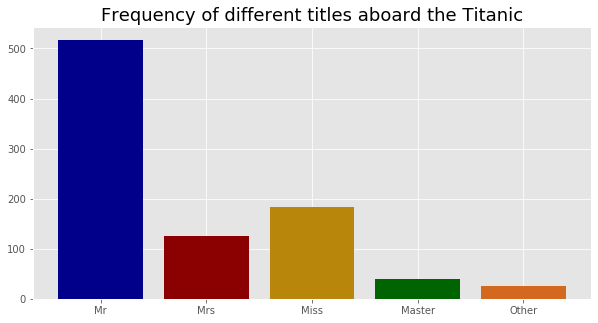

In [15]:
# Plotting the frequency of different titles
plt.bar(unique_titles, height=[len(mr), len(mrs), len(miss), len(master), len(other)], 
        color=['darkblue', 'darkred', 'darkgoldenrod', 'darkgreen', 'chocolate'])
plt.title('Frequency of different titles aboard the Titanic', fontsize=18)
plt.show()

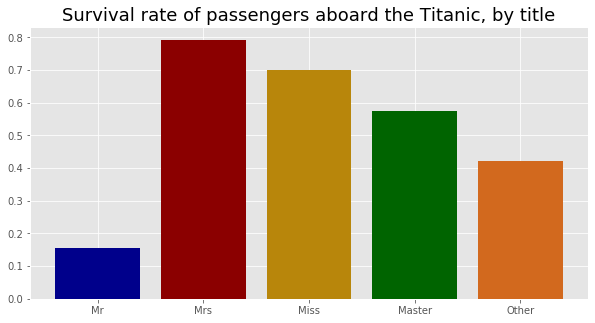

In [16]:
# Calculate avg survival rates
mr_avg_surv = mr['Survived'].mean()
mrs_avg_surv = mrs['Survived'].mean()
miss_avg_surv = miss['Survived'].mean()
master_avg_surv = master['Survived'].mean()
other_avg_surv = other['Survived'].mean()

# Plotting the survival rate of different titles
plt.bar(unique_titles, 
        height=[mr_avg_surv, mrs_avg_surv, miss_avg_surv, master_avg_surv, other_avg_surv], 
        color=['darkblue', 'darkred', 'darkgoldenrod', 'darkgreen', 'chocolate'])

plt.title('Survival rate of passengers aboard the Titanic, by title', fontsize=18)

plt.show()

Next, I will compare the accuracy of two different K-Nearest-Neighbours classifiers. One will only recieve ticket fare as input feature, while the other will recieve both ticket fare and title.

In [17]:
# Preparing dataset for KNN Classifier
# Converting titles to numeric
titanic.Title.replace(
    to_replace=['Mr', 'Mrs', 'Other', 'Master', 'Miss'],
    value=[1, 2, 3, 4, 5], inplace=True)

# KNN only accepts 2-dimensional arrays
X1 = titanic.Fare.values.reshape(-1, 1) 
X2 = titanic[['Fare', 'Title']]
y = titanic.Survived

# Fitting and measuring the accuracy of a KNN Classifier on the dataset using only 'Fare' as input and 'Survival' as output
X1_train, X1_val, y_train, y_val = train_test_split(X1, y, test_size=0.2, random_state=1)   # Splitting dataset into train and test
clf_on_fare = KNeighborsClassifier(n_neighbors=30, weights='uniform')
clf_on_fare.fit(X=X1_train, y=y_train)
y_pred_on_fare = clf_on_fare.predict(X1_val)
print(accuracy_score(y_val, y_pred_on_fare))


# Fitting a KNN Classifier on the dataset using 'Fare' and 'Title' as input and 'Survival' as output
# Splitting dataset into train and test
X2_train, X2_val, y_train, y_val = train_test_split(X2, y, test_size=0.2, random_state=1)
# Building and fitting a model with n_neighbors = 30
clf_on_fare = KNeighborsClassifier(n_neighbors=30, weights='uniform')
clf_on_fare.fit(X=X2_train, y=y_train)
# Measuring prediction accuracy
y_pred_on_fare_and_title = clf_on_fare.predict(X2_val)
print(accuracy_score(y_val, y_pred_on_fare_and_title))

0.664804469273743
0.7318435754189944


We can observe a 10.1% increase in prediction accuracy when fitting the model on passenger titles and ticket fare, as opposed to just fitting it on ticket fare. We can therefore conclude that the title (and status) of the passengers aboard the Titanic affected their survival rate.